In [1]:
# Imports

import os
import joblib
import pandas as pd

from modsec import init_modsec
from utils import (
    get_rules_list,
    create_train_test_split,
    train_model,
    create_adv_train_test_split,
    test_evasion,
    log,
    load_data_label_vector,
)
from config import BaseConfig

In [2]:
# Setup Variables

Config = BaseConfig()

data_path = max( # use the most recent prepared data
    [os.path.join("data/prepared/", d) for d in os.listdir("data/prepared/")],
    key=os.path.getmtime,
)

In [3]:
# Load Data

train = load_data_label_vector(f"{data_path}/train.csv")
test = load_data_label_vector(f"{data_path}/test.csv")
train_adv = load_data_label_vector(f"{data_path}/train_adv.csv")
test_adv = load_data_label_vector(f"{data_path}/test_adv.csv")

Model trained successfully!
Evaluating model...
Default threshold: 0.5
FRP is currently at 0.0086
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       100
           1       0.99      0.96      0.97       120

    accuracy                           0.97       220
   macro avg       0.97      0.97      0.97       220
weighted avg       0.97      0.97      0.97       220



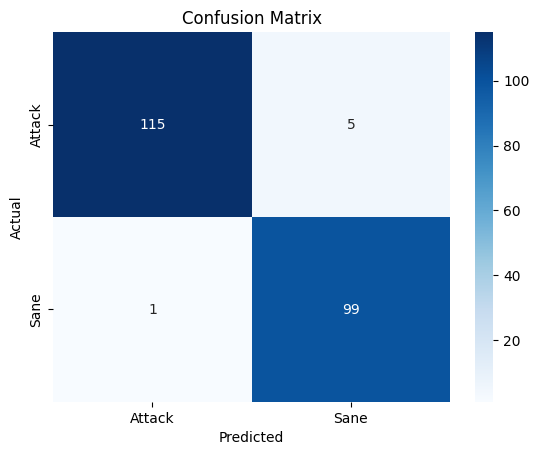

Adjusting threshold to match desired FPR of 0.01


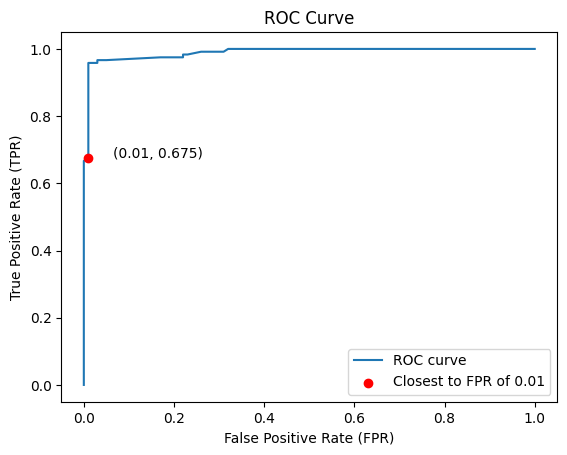

Adjusted threshold: 0.925 with FPR of 0.01 (closest to desired FPR 0.01)
              precision    recall  f1-score   support

           0       0.72      0.99      0.83       100
           1       0.99      0.68      0.80       120

    accuracy                           0.82       220
   macro avg       0.85      0.83      0.82       220
weighted avg       0.86      0.82      0.82       220



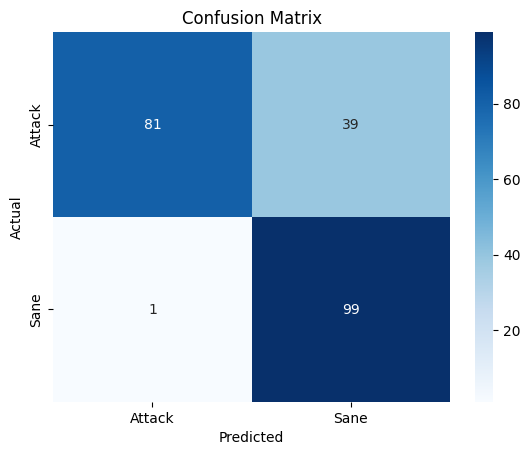

In [4]:
# Load/Train Models

model_trained = joblib.load(f"{data_path}/model.joblib")
threshold = float(open(f"{data_path}/threshold.txt", "r").read())

model_adv_trained, threshold_adv = train_model(
    train=pd.concat([train, train_adv]).sample(frac=1).reset_index(drop=True),
    test=pd.concat([test, test_adv]).sample(frac=1).reset_index(drop=True),
    model=Config.MODEL_ADV,
    desired_fpr=Config.DESIRED_FPR,
)

In [5]:
# Test Evasion (base model without adversarial training)

test_evasion(
    payload='SELECT SLEEP(5)#";',
    threshold=threshold,
    model=model_trained,
    engine_eval_settings={
        "max_rounds": 200,
        "round_size": 10,
        "timeout": 60,
        "threshold": 0.0,
    },
    modsec=init_modsec(),
    rule_ids=Config.RULE_IDS,
    paranoia_level=Config.PARANOIA_LEVEL,
)

Payload: SELECT SLEEP(5)#";
Vec: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
Confidence: 0.863
[!] Max number of iterations reached
Reached confidence 0.564717100059916
with payload
SElECt slEeP(0x5)      &&     9xp=9XP aNd tRuE#";47
Min payload: b'SElECt slEeP(0x5)      &&     \x0c9xp=9XP aNd tRuE#";47'
Min confidence: 0.56472
Reduced confidence from 0.863 to 0.56472 (reduction of 0.29829)

Evasion successful


In [6]:
# Test Evasion (adversarially trained model)

test_evasion(
    payload='SELECT SLEEP(5)#";',
    threshold=threshold,
    model=model_adv_trained,
    engine_eval_settings={
        "max_rounds": 200,
        "round_size": 10,
        "timeout": 60,
        "threshold": 0.0,
    },
    modsec=init_modsec(),
    rule_ids=Config.RULE_IDS,
    paranoia_level=Config.PARANOIA_LEVEL,
)

Payload: SELECT SLEEP(5)#";
Vec: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
Confidence: 0.91388
[!] Max number of iterations reached
Reached confidence 0.6647569444444444
with payload
seLeCT SleEp(0X5) OR 'YOB' nOT   =  'YOb' or fALse#";$Y
Min payload: b'seLeCT SleEp(0X5) OR \'YOB\' nOT   =  \x0b\'YOb\' or fALse#";$Y'
Min confidence: 0.66476
Reduced confidence from 0.91388 to 0.66476 (reduction of 0.24913)

Evasion successful


: 